# Movimiento browniano y movimiento browniano geométrico

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tabulate import tabulate
from scipy.stats import norm
from math import comb
plt.style.use('ggplot')

### Parámetros
- $t$: Valor para el cual se simula el movimiento browniano
- $n$: Valor (grande) tal que $t/n$ sea el tamaño de paso
- $\mu$: Media 
- $\sigma$: Varianza
- $x$: Valor inicial de la trayectoria


La función **MB** regresa una lista con una trayectoria simulando un movimiento browniano de media $\mu$, varianza $\sigma$, con tamaño de paso $t/n$. 

La función **GBM** regresa una lista con la trayectoria simulando un movimiento browniano geométrico.

Después, se simulan diferentes trayectorias para diferentes tamaños de paso, para ambos procesos. Se usa $t=10, \mu=0, \sigma = 1$ y $x=0$.

In [143]:
def MB(t,n,mu,sigma,x):
    ran = []
    for i in range(n):
        Z = np.random.normal(0,1)
        W = mu*(t/n) + sigma*np.sqrt(t/n)*Z
        ran.append(W)
    suma = np.cumsum(ran)+x
    mb = np.insert(suma,0,x)
    return(mb)

def GBM(t,n,mu,sigma,x):
    S = x*np.exp(MB(t,n,mu,sigma,0))
    return(S)

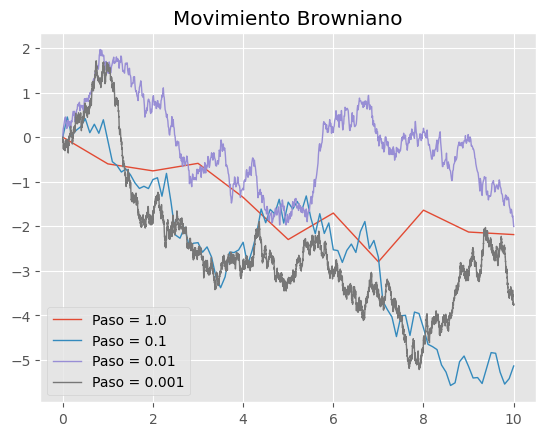

In [4]:
n = [10,100,1000,10000]
for i in n:
    X = np.linspace(0,10,i+1)
    paso = 10/i
    plt.plot(X,MB(10,i,0,1,0), label = "Paso = "+str(paso), linewidth = 1)
    plt.legend()
plt.title("Movimiento Browniano")
plt.show()

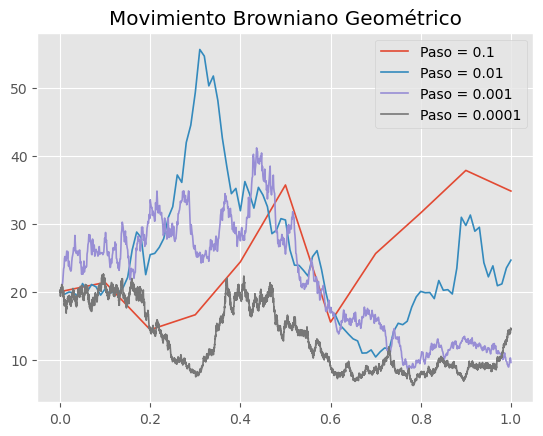

In [144]:
N = [10,100,1000,10000]
for i in N:
    X = np.linspace(0,1,i+1)
    paso = 1/i
    plt.plot(X,GBM(1,i,0,1,20), label = "Paso = "+str(round(paso,4)), linewidth = 1.2)
    plt.legend()
plt.title("Movimiento Browniano Geométrico")
plt.show()

# Black-Scholes

### Parámetros
- $S(y)$: Precio de la acción al tiempo $y$
- $s$: Precio inicial de la acción, $S(0)=s$
- $t$: Tiempo de vencimiento
- $K$: Precio de ejercicio
- $\sigma$: Volatilidad de la acción 
- $r$: Tasa de interés nominal (continua)

In [147]:
s = 30
t = 0.25
K = 34
sigma = 0.2
r = 0.08
mu = r-(sigma**2)/2

### Precio C exacto
La función **omega** es:
$$\omega = \frac{rt+ \sigma^2t/2-\log(K/s)}{\sigma \sqrt{t}}$$
La función **C** es la fórmula de Black-Scholes para el precio único y libre de riesgo para una opción, bajo el supuesto de que el precio de la acción sigue un movimiento browniano geométrico.
$$C(s,t,K,\sigma,r) = s\Phi(\omega)-Ke^{-rt}\Phi(\omega-\sigma \sqrt{t})$$
$\Phi(x)$ es la función de distribución normal estándar.

In [97]:
def omega(r,t,sig,K,s):
    return (r*t + (sig**2)*(t/2) - np.log(K/s))/(sig*np.sqrt(t))

def C(s=s,t=t,K=K,sig=sigma,r=r):
    w = omega(r,t,sig,K,s)
    return s*norm.cdf(w) - K*np.exp(-r*t)*norm.cdf(w - sig*np.sqrt(t))

In [98]:
start = timer()
Cbs = C(s,t,K,sigma,r)
end = timer()
Cbs 

0.23834902311962214

In [99]:
end-start 

0.00039200000173877925

### Precio C simulado
La función **intr_bs** regresa el valor intrínseco de la opción al tiempo $t$, con 1 variable aleatoria normal.

La función **C_bs** simula el valor presente esperado del valor intrínseco al tiempo $t$. 

In [109]:
def intr_bs(s=s, t=t, K=K, sigma = sigma, r=r):
    Z = np.random.normal(0,1)
    W = r*t-(sigma**2)*(t/2) + sigma*np.sqrt(t)*Z
    value = max(s*np.exp(W)-K,0)
    return value

#N es el número de iteraciones para simular la esperanza
def C_bs(N,s=s,t=t,K=K,sigma=sigma,r=r):
    cont = 0
    for i in range(0,N):
        cont += intr_bs(s,t,K,sigma,r)
    E = cont/N
    c = (np.e**(-r*t))*E
    return(c)


In [110]:
C_bs(10000,s,t,K,sigma,r)

0.23419292823013102

### Comparación simulación y fórmula cerrada
Se muestra una tabla con el tiempo y error relativo, para diferentes valores de $N$ y diferente número de $C$ simulados y promediados

Los resultados se muestran también gráficamente

Por último un histograma de precios $C$ aproximados.

In [114]:
def tiempo(it,N,s=s,t=t,K=K,sigma=sigma,r=r):
    start = timer()
    l = [C_bs(N,s,t,K,sigma,r) for _ in range(it)]
    C_sim = sum(l)/it
    end = timer()
    error = abs(C_sim - C())/C()
    return(end-start,error)

In [106]:
tabla = [["# Precios C", "N", "Tiempo Simulacion", "Error relativo"],
         [1, 1000, tiempo(it=1,N=1000)[0], tiempo(it=1, N = 1000)[1]],         
         [1, 10000, tiempo(it=1,N=10000)[0], tiempo(it=1, N = 10000)[1]],         
         [100, 1000, tiempo(it=100,N=1000)[0], tiempo(it=100, N = 1000)[1]],         
         [100, 10000, tiempo(it=100,N=10000)[0], tiempo(it=100, N = 10000)[1]]]

In [111]:
print(tabulate(tabla, headers = "firstrow", tablefmt = "fancy_grid"))

╒═══════════════╤═══════╤═════════════════════╤══════════════════╕
│   # Precios C │     N │   Tiempo Simulacion │   Error relativo │
╞═══════════════╪═══════╪═════════════════════╪══════════════════╡
│             1 │  1000 │           0.006086  │      0.0369983   │
├───────────────┼───────┼─────────────────────┼──────────────────┤
│             1 │ 10000 │           0.0756972 │      0.0730655   │
├───────────────┼───────┼─────────────────────┼──────────────────┤
│           100 │  1000 │           0.646479  │      0.0135452   │
├───────────────┼───────┼─────────────────────┼──────────────────┤
│           100 │ 10000 │           6.72328   │      0.000663711 │
╘═══════════════╧═══════╧═════════════════════╧══════════════════╛


In [118]:
Cs = [1,10,20,30,40,50,60,70,80,90,100]
ti = [tiempo(it=i,N=10000)[0] for i in Cs]
error = [tiempo(it=i,N=10000)[1] for i in Cs]

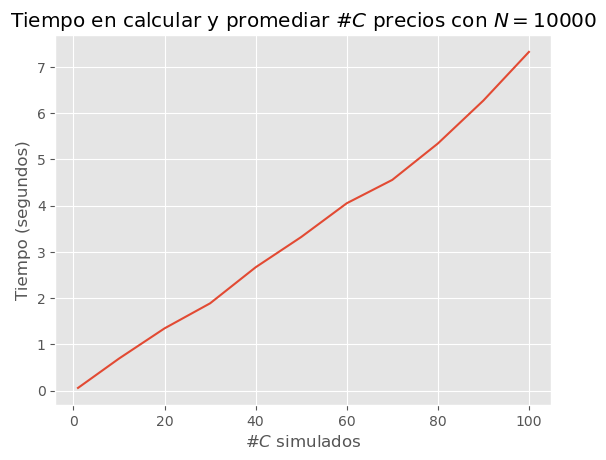

In [120]:
plt.plot(Cs,ti)
plt.xlabel("#$C$ simulados")
plt.ylabel("Tiempo (segundos)")
plt.title("Tiempo en calcular y promediar #$C$ precios con $N=10000$")
plt.show()

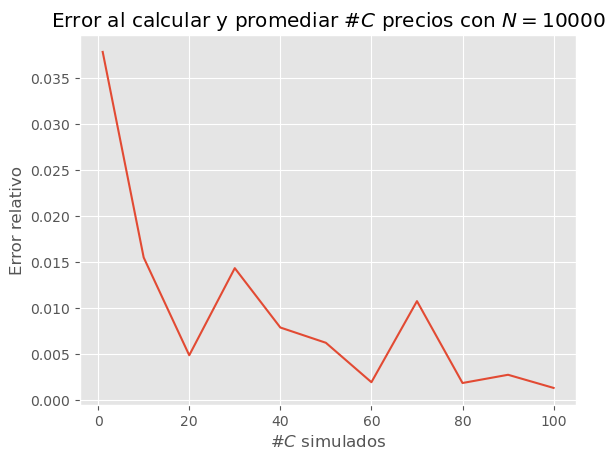

In [122]:
plt.plot(Cs,error)
plt.xlabel("#$C$ simulados")
plt.ylabel("Error relativo")
plt.title("Error al calcular y promediar #$C$ precios con $N=10000$")
plt.show()

In [75]:
sim = [C_bs(1000,s,t,K,sigma,r) for _ in range(500)]

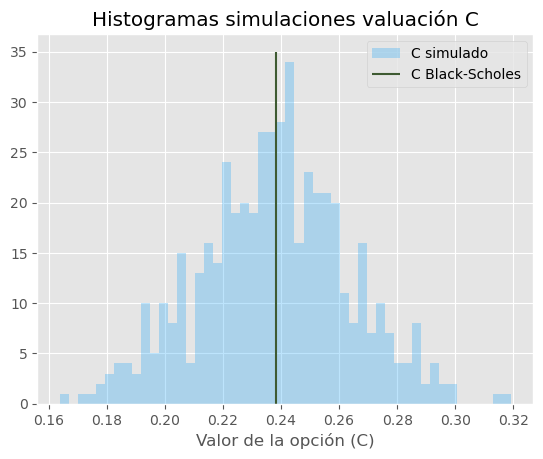

In [78]:
plt.xlabel("Valor de la opción (C)")
plt.title("Histograma aproximaciones valuación C")
plt.hist(sim, bins = 50,color = '#27A8F7',alpha = 0.3, label = "C simulado")
plt.vlines(Cbs,0,35, color = "#3E5A32", label = "C Black-Scholes" )
plt.legend()
plt.show()

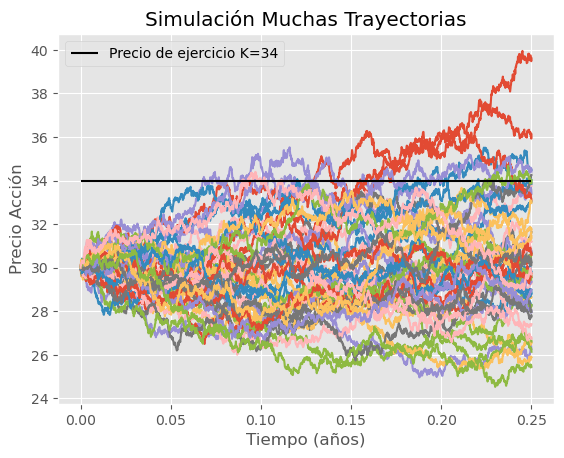

In [166]:
for i in range(1,50):
    X = np.linspace(0,t,2000+1)
    paso = 1/2000
    plt.plot(X,GBM(t,2000,mu,sigma,s))
plt.hlines(K,0,t,color = "#000000", label = "Precio de ejercicio K="+str(K))
plt.xlabel("Tiempo (años)")
plt.ylabel("Precio Acción")
plt.title("Simulación Muchas Trayectorias")
plt.legend()
plt.show()